In [2]:
import sys
import os
import socket
import datetime

from pyspark.conf import SparkConf
from pyspark.context import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import types as T
from pyspark.sql.avro.functions import from_avro
from pyspark.sql.window import Window

import pandas as pd
import numpy as np

In [3]:
import pandas as pd
from pretrainer import *
from fsspec.implementations import hdfs

import xgboost as xgb
from sklearn.feature_selection import GenericUnivariateSelect, chi2, f_classif
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.model_selection import train_test_split
import pickle

import os
from datetime import date
import socket
import sys
from glob import glob

from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql.types import StructType, StructField, LongType, ArrayType, DoubleType, StringType
from pyspark.sql.window import Window
from pyspark.sql import functions as F
from pyspark.sql.functions import udf
from pyspark.sql import types as T
from datetime import date, timedelta
from pyspark.sql.types import LongType
import pyspark.sql.functions as func

In [4]:
sparkHome = "/apache/spark3.1"
bxPexFile = "bx_pex_env_5_9_1.pex"
os.environ["SPARK_HOME"] = sparkHome
os.environ["PYSPARK_PYTHON"] = f"./{bxPexFile}"
os.environ["PYSPARK_DRIVER_PYTHON"] = "/usr/share/anaconda3/python3.7/bin/python"
sys.path.append(f"{sparkHome}/python/lib/py4j-0.10.9-src.zip")
sys.path.append(f"{sparkHome}/python")

host_ip = socket.gethostbyname(socket.gethostname())

spark = SparkSession \
    .builder \
    .appName("click_propensity_estimator_" + os.environ["KRYLOV_PRINCIPAL"]) \
    .master("yarn") \
    .config("spark.driver.maxResultSize", "15g")\
    .config("spark.driver.host", host_ip) \
    .config("spark.driver.port", "30202") \
    .config("spark.yarn.executor.memoryOverhead", "32g") \
    .config("spark.executor.cores", "3") \
    .config("spark.driver.memory", "25g") \
    .config("spark.executor.memory", "25g") \
    .config("spark.rdd.compress", True) \
    .config("spark.network.timeout", "600s") \
    .config("spark.executor.heartbeatInterval", "300s") \
    .config("spark.sql.broadcastTimeout", "1200s") \
    .config("spark.dynamicAllocation.minExecutors", 0) \
    .config("spark.dynamicAllocation.initialExecutors", 100) \
    .config("spark.dynamicAllocation.maxExecutors", 10000) \
    .config("spark.sql.shuffle.partitions", 512)\
    .config("spark.kryoserializer.buffer.max", "1g")\
    .config("spark.rpc.message.maxSize", 1024)\
    .config("spark.yarn.queue", "hddq-exprce-perso-high-mem") \
    .config("spark.driver.maxResultSize", "0") \
    .config("spark.files", f"viewfs://apollo-rno/user/b_perso/pex_environments/{bxPexFile}") \
    .enableHiveSupport() \
    .getOrCreate()

spark


SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/apache/releases/hadoop-2.7.3.2.6.4.2.0.38/share/hadoop/common/lib/slf4j-log4j12-1.7.30.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/apache/releases/hbase-1.1.2.2.6.4.1.0.3/lib/slf4j-log4j12-1.7.10.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.slf4j.impl.Log4jLoggerFactory]
23/01/15 11:30:20 WARN SparkConf: The configuration key 'spark.yarn.executor.memoryOverhead' has been deprecated as of Spark 2.3 and may be removed in the future. Please use the new key 'spark.executor.memoryOverhead' instead.
23/01/15 11:30:20 WARN SparkConf: The configuration key 'spark.yarn.executor.memoryOverhead' has been deprecated as of Spark 2.3 and may be removed in the future. Please use the new key 'spark.executor.memoryOverhead' instead.


2023-01-15T11:30:21.827+0000: [Full GC (Metadata GC Threshold) 2023-01-15T11:30:21.827+0000: [Tenured: 0K->17104K(1398144K), 0.1308085 secs] 234903K->17104K(2027264K), [Metaspace: 20273K->20273K(1067008K)], 0.1309011 secs] [Times: user=0.08 sys=0.06, real=0.12 secs] 


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/01/15 11:30:24 WARN SparkConf: The configuration key 'spark.yarn.executor.memoryOverhead' has been deprecated as of Spark 2.3 and may be removed in the future. Please use the new key 'spark.executor.memoryOverhead' instead.
23/01/15 11:30:24 WARN SparkConf: The configuration key 'spark.yarn.executor.memoryOverhead' has been deprecated as of Spark 2.3 and may be removed in the future. Please use the new key 'spark.executor.memoryOverhead' instead.
23/01/15 11:30:24 WARN SparkConf: The configuration key 'spark.yarn.executor.memoryOverhead' has been deprecated as of Spark 2.3 and may be removed in the future. Please use the new key 'spark.executor.memoryOverhead' instead.


2023-01-15T11:30:24.935+0000: [Full GC (Metadata GC Threshold) 2023-01-15T11:30:24.935+0000: [Tenured: 17104K->30509K(1398144K), 0.1940228 secs] 408841K->30509K(2027392K), [Metaspace: 33969K->33969K(1079296K)], 0.1941016 secs] [Times: user=0.14 sys=0.07, real=0.20 secs] 


23/01/15 11:30:25 WARN Utils: Service 'sparkDriver' could not bind on port 30202. Attempting port 30203.
23/01/15 11:30:26 WARN Utils: Service 'SparkUI' could not bind on port 30401. Attempting port 30402.


2023-01-15T11:30:34.131+0000: [Full GC (Metadata GC Threshold) 2023-01-15T11:30:34.131+0000: [Tenured: 30509K->50012K(1398144K), 0.2247924 secs] 428799K->50012K(2027392K), [Metaspace: 56378K->56378K(1101824K)], 0.2248837 secs] [Times: user=0.16 sys=0.06, real=0.22 secs] 


23/01/15 11:30:36 WARN HiveConf: DEPRECATED: hive.metastore.ds.retry.* no longer has any effect.  Use hive.hmshandler.retry.* instead
23/01/15 11:30:36 WARN HiveConf: HiveConf of name hive.metastore.local does not exist
23/01/15 11:30:36 WARN HiveConf: HiveConf of name hive.enforce.sorting does not exist
23/01/15 11:30:36 WARN HiveConf: HiveConf of name hive.server2.proxyuser.hue.groups does not exist
23/01/15 11:30:36 WARN HiveConf: HiveConf of name hive.server2.proxyuser.hue.hosts does not exist
23/01/15 11:30:36 WARN HiveConf: HiveConf of name hive.metastore.ds.retry.interval does not exist
23/01/15 11:30:36 WARN HiveConf: HiveConf of name hive.enforce.bucketing does not exist
23/01/15 11:30:36 WARN HiveConf: HiveConf of name hive.metastore.ds.retry.attempts does not exist
23/01/15 11:30:36 WARN HiveConf: HiveConf of name hive.server2.enable.impersonation does not exist
23/01/15 11:30:37 WARN SparkConf: The configuration key 'spark.yarn.executor.memoryOverhead' has been deprecated a

2023-01-15T11:30:45.890+0000: [GC (Allocation Failure) 2023-01-15T11:30:45.890+0000: [DefNew
Desired survivor size 35782656 bytes, new threshold 15 (max 15)
- age   1:   29441736 bytes,   29441736 total
: 559360K->28751K(629248K), 0.0610120 secs] 609372K->78764K(2027392K), 0.0610775 secs] [Times: user=0.04 sys=0.02, real=0.06 secs] 


23/01/15 11:34:31 WARN Utils: Service 'org.apache.spark.network.netty.NettyBlockTransferService' could not bind on port 30601. Attempting port 30602.


2023-01-15T11:34:35.025+0000: [Full GC (Metadata GC Threshold) 2023-01-15T11:34:35.025+0000: [Tenured: 50012K->41559K(1398144K), 0.2257530 secs] 589512K->41559K(2027392K), [Metaspace: 93201K->93201K(1134592K)], 0.2258807 secs] [Times: user=0.21 sys=0.02, real=0.23 secs] 


In [5]:
spark

# click-propensity

In [6]:
schema = T.StructType(
    [
        T.StructField('siteId', T.IntegerType(), True),
        T.StructField('placementId', T.IntegerType(), True),
        T.StructField('displayRank', T.IntegerType(), True),
        T.StructField('clickPropensity', T.FloatType(), True),
        T.StructField('purchasePropensity', T.FloatType(), True),
        T.StructField('n', T.IntegerType(), True)
    ]
)

#path = "viewfs://apollo-rno/apps/b_perso/hp/click_propensity/mad_cdl/position_bias.tsv"
path = "viewfs://apollo-rno/apps/b_perso/hp/click_propensity/prod/position_bias.tsv"
clickCount = spark.read.option("header", True).schema(schema).option("delimiter", "\t").csv(path)


In [7]:

w = Window.partitionBy("siteId", "placementId").orderBy([F.col("displayRank").asc()])

clickCount1 = clickCount \
    .withColumn("bias1", F.first("clickPropensity", True).over(w)) \
    .withColumn("biasK", F.col("clickPropensity")) \
    .withColumn("propensity_pretrainer", F.col("biasK") / F.col("bias1")) \
    .withColumn("propensity_impression_weights", 1 / F.col("propensity_pretrainer"))



In [8]:
pdf = clickCount1.toPandas()

23/01/15 11:34:53 WARN YarnScheduler: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registered and have sufficient resources
23/01/15 11:35:08 WARN YarnScheduler: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registered and have sufficient resources
23/01/15 11:35:23 WARN YarnScheduler: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registered and have sufficient resources
23/01/15 11:35:38 WARN YarnScheduler: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registered and have sufficient resources
23/01/15 11:35:53 WARN YarnScheduler: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registered and have sufficient resources
23/01/15 11:36:08 WARN YarnScheduler: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registere

2023-01-15T11:42:49.574+0000: [GC (Allocation Failure) 2023-01-15T11:42:49.574+0000: [DefNew
Desired survivor size 35782656 bytes, new threshold 15 (max 15)
- age   1:   33019208 bytes,   33019208 total
: 559360K->32245K(629248K), 0.1851378 secs] 600919K->73804K(2027392K), 0.1853869 secs] [Times: user=0.14 sys=0.05, real=0.19 secs] 


In [9]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows',40)

In [10]:
pdf.head(10)

,siteId,placementId,displayRank,clickPropensity,purchasePropensity,n,bias1,biasK,propensity_pretrainer,propensity_impression_weights
0,2,101278,1,0.000917,211508.0,NaN,0.000917,0.000917,1.000000,1.000000
1,2,101278,2,0.000674,13355.0,NaN,0.000917,0.000674,0.734723,1.361057
2,2,101278,3,0.000998,7014.0,NaN,0.000917,0.000998,1.088071,0.919057
3,2,101278,4,0.000881,17027.0,NaN,0.000917,0.000881,0.960458,1.041170
4,2,101278,5,0.000274,62035.0,NaN,0.000917,0.000274,0.298770,3.347055
5,2,101278,6,0.000222,13516.0,NaN,0.000917,0.000222,0.241990,4.132395
6,2,101278,7,0.000000,71.0,NaN,0.000917,0.000000,0.000000,NaN
7,2,101278,8,0.000000,181.0,NaN,0.000917,0.000000,0.000000,NaN
8,2,101278,9,0.000225,17759.0,NaN,0.000917,0.000225,0.245565,4.072241
9,2,101278,10,0.000000,3784.0,NaN,0.000917,0.000000,0.000000,NaN


In [11]:
pdf.shape

(966, 10)

In [12]:
pdf.columns

Index(['siteId', 'placementId', 'displayRank', 'clickPropensity',
       'purchasePropensity', 'n', 'bias1', 'biasK', 'propensity_pretrainer',
       'propensity_impression_weights'],
      dtype='object')

In [13]:
pdf.columns

Index(['siteId', 'placementId', 'displayRank', 'clickPropensity',
       'purchasePropensity', 'n', 'bias1', 'biasK', 'propensity_pretrainer',
       'propensity_impression_weights'],
      dtype='object')

2023-01-15T12:04:34.112+0000: [Full GC (System.gc()) 2023-01-15T12:04:34.112+0000: [Tenured: 41559K->56397K(1398144K), 0.3710877 secs] 493689K->56397K(2027392K), [Metaspace: 129803K->129803K(1173504K)], 0.3712429 secs] [Times: user=0.29 sys=0.08, real=0.37 secs] 
2023-01-15T12:34:34.112+0000: [Full GC (System.gc()) 2023-01-15T12:34:34.113+0000: [Tenured: 56397K->56948K(1398144K), 0.5505074 secs] 278194K->56948K(2027392K), [Metaspace: 129878K->129878K(1173504K)], 0.5508526 secs] [Times: user=0.50 sys=0.03, real=0.55 secs] 
2023-01-15T13:04:34.112+0000: [Full GC (System.gc()) 2023-01-15T13:04:34.112+0000: [Tenured: 56948K->57809K(1398144K), 0.2711255 secs] 279245K->57809K(2027392K), [Metaspace: 129949K->129949K(1173504K)], 0.2712150 secs] [Times: user=0.22 sys=0.05, real=0.27 secs] 
2023-01-15T13:34:34.112+0000: [Full GC (System.gc()) 2023-01-15T13:34:34.112+0000: [Tenured: 57809K->43184K(1398144K), 0.2661235 secs] 276831K->43184K(2027392K), [Metaspace: 130033K->130033K(1173504K)], 0.266

In [13]:
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

In [14]:
clickPropensity=pdf[['siteId','placementId','displayRank','clickPropensity']].drop_duplicates().sort_values(by='siteId')

In [15]:
piyi=[101251, 101259, 101260]

In [17]:
clickPropensity[(clickPropensity["placementId"]==piyi[0] ) & (clickPropensity["siteId"]==0) ].sort_values(by='displayRank')

,siteId,placementId,displayRank,clickPropensity
69,0,101251,2,0.003854
70,0,101251,3,0.002029
71,0,101251,4,0.001776
72,0,101251,5,0.001604
73,0,101251,6,0.001326
74,0,101251,7,0.001155
75,0,101251,8,0.001172
76,0,101251,9,0.001085
77,0,101251,10,0.001307


In [18]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
clickPropensity[(clickPropensity["placementId"]==piyi[1]) & (clickPropensity["siteId"]==0) ].sort_values(by='displayRank')

,siteId,placementId,displayRank,clickPropensity
504,0,101259,1,0.002021
505,0,101259,2,0.001875
506,0,101259,3,0.001003
507,0,101259,4,0.000921
508,0,101259,5,0.000587
509,0,101259,6,0.000613
510,0,101259,7,0.000601
511,0,101259,8,0.000465
512,0,101259,9,0.000511
513,0,101259,10,0.000552


In [21]:
clickPropensity[(clickPropensity["placementId"]==101251) & (clickPropensity["siteId"]==0) ].sort_values(by='displayRank')

,siteId,placementId,displayRank,clickPropensity
69,0,101251,2,0.003854
70,0,101251,3,0.002029
71,0,101251,4,0.001776
72,0,101251,5,0.001604
73,0,101251,6,0.001326
74,0,101251,7,0.001155
75,0,101251,8,0.001172
76,0,101251,9,0.001085
77,0,101251,10,0.001307


In [16]:
pdf[(pdf["placementId"]==101251) & (pdf["siteId"]==0) ].sort_values(by='displayRank')

,siteId,placementId,displayRank,clickPropensity,purchasePropensity,n,bias1,biasK,propensity_pretrainer,propensity_impression_weights
69,0,101251,2,0.003854,782992.0,NaN,0.003854,0.003854,1.000000,1.000000
70,0,101251,3,0.002029,426317.0,NaN,0.003854,0.002029,0.526407,1.899671
71,0,101251,4,0.001776,425598.0,NaN,0.003854,0.001776,0.460851,2.169900
72,0,101251,5,0.001604,383366.0,NaN,0.003854,0.001604,0.416198,2.402705
73,0,101251,6,0.001326,351317.0,NaN,0.003854,0.001326,0.344132,2.905863
74,0,101251,7,0.001155,303900.0,NaN,0.003854,0.001155,0.299650,3.337225
75,0,101251,8,0.001172,286715.0,NaN,0.003854,0.001172,0.304037,3.289069
76,0,101251,9,0.001085,269032.0,NaN,0.003854,0.001085,0.281590,3.551264
77,0,101251,10,0.001307,233384.0,NaN,0.003854,0.001307,0.339052,2.949396


2023-01-15T10:22:03.000+0000: [Full GC (System.gc()) 2023-01-15T10:22:03.000+0000: [Tenured: 42191K->55957K(1398144K), 0.4330410 secs] 617016K->55957K(2027392K), [Metaspace: 130113K->130113K(1173504K)], 0.4332245 secs] [Times: user=0.30 sys=0.13, real=0.43 secs] 
2023-01-15T10:52:03.000+0000: [Full GC (System.gc()) 2023-01-15T10:52:03.000+0000: [Tenured: 55957K->56525K(1398144K), 0.2869046 secs] 278903K->56525K(2027392K), [Metaspace: 130176K->130176K(1173504K)], 0.2870029 secs] [Times: user=0.22 sys=0.07, real=0.29 secs] 
2023-01-15T11:22:03.000+0000: [Full GC (System.gc()) 2023-01-15T11:22:03.000+0000: [Tenured: 56525K->57272K(1398144K), 0.2486456 secs] 277410K->57272K(2027392K), [Metaspace: 130233K->130233K(1173504K)], 0.2487370 secs] [Times: user=0.23 sys=0.02, real=0.25 secs] 


In [23]:
pdf[(pdf["placementId"]==101259) & (pdf["siteId"]==0) ].sort_values(by='displayRank')

,siteId,placementId,displayRank,clickPropensity,purchasePropensity,n,bias1,biasK,propensity_pretrainer,propensity_impression_weights
504,0,101259,1,0.002021,10703815.0,NaN,0.002021,0.002021,1.000000,1.000000
505,0,101259,2,0.001875,475326.0,NaN,0.002021,0.001875,0.927573,1.078082
506,0,101259,3,0.001003,258205.0,NaN,0.002021,0.001003,0.496360,2.014665
507,0,101259,4,0.000921,258407.0,NaN,0.002021,0.000921,0.455758,2.194145
508,0,101259,5,0.000587,233332.0,NaN,0.002021,0.000587,0.290542,3.441848
509,0,101259,6,0.000613,217068.0,NaN,0.002021,0.000613,0.303192,3.298239
510,0,101259,7,0.000601,188064.0,NaN,0.002021,0.000601,0.297327,3.363297
511,0,101259,8,0.000465,178529.0,NaN,0.002021,0.000465,0.230055,4.346790
512,0,101259,9,0.000511,168344.0,NaN,0.002021,0.000511,0.252792,3.955826
513,0,101259,10,0.000552,150289.0,NaN,0.002021,0.000552,0.273283,3.659208


In [24]:
pdf[(pdf["placementId"]==101260) & (pdf["siteId"]==0) ].sort_values(by='displayRank')

,siteId,placementId,displayRank,clickPropensity,purchasePropensity,n,bias1,biasK,propensity_pretrainer,propensity_impression_weights
88,0,101260,1,0.001683,7838416.0,NaN,0.001683,0.001683,1.000000,1.000000
89,0,101260,2,0.001585,328755.0,NaN,0.001683,0.001585,0.941565,1.062062
90,0,101260,3,0.000872,180000.0,NaN,0.001683,0.000872,0.518217,1.929692
91,0,101260,4,0.000713,179455.0,NaN,0.001683,0.000713,0.423779,2.359722
92,0,101260,5,0.000666,163573.0,NaN,0.001683,0.000666,0.395913,2.525808
93,0,101260,6,0.000478,150637.0,NaN,0.001683,0.000478,0.283979,3.521392
94,0,101260,7,0.000478,131677.0,NaN,0.001683,0.000478,0.284260,3.517909
95,0,101260,8,0.000455,125397.0,NaN,0.001683,0.000455,0.270068,3.702777
96,0,101260,9,0.000495,119149.0,NaN,0.001683,0.000495,0.294203,3.399019
97,0,101260,10,0.000450,106776.0,NaN,0.001683,0.000450,0.267087,3.744102


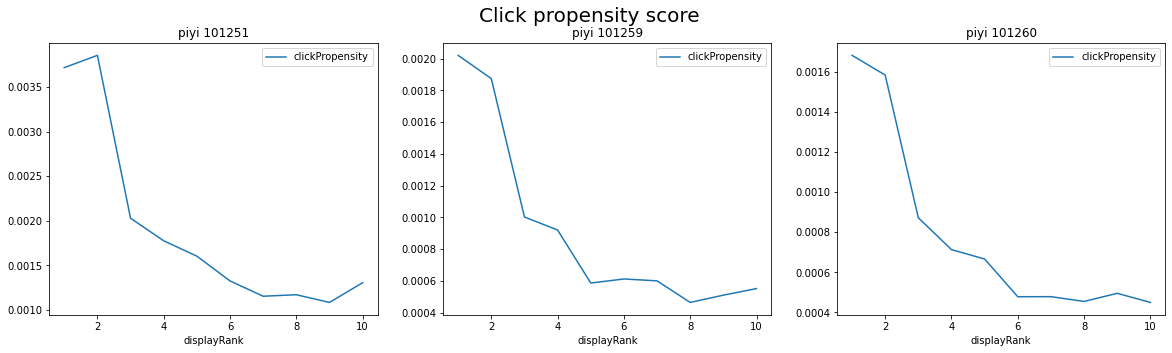

In [52]:

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,5))
plt.suptitle("Click propensity score",fontsize=20)
pdf[(pdf["placementId"]==101251) & (pdf["siteId"]==0) ].plot(ax=axes[0],x='displayRank',y='clickPropensity', title='piyi 101251')
pdf[(pdf["placementId"]==101259)&(pdf["siteId"]==0)].plot(ax=axes[1],x='displayRank',y='clickPropensity', title='piyi 101259')
pdf[(pdf["placementId"]==101260)&(pdf["siteId"]==0)].plot(ax=axes[2],x='displayRank',y='clickPropensity', title='piyi 101260')

plt.show()

interactive(children=(Dropdown(description='placementId', options=(101251, 101259, 101260, 101278, 101279, 101…

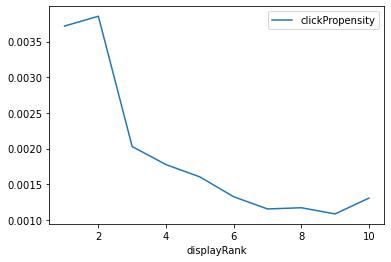

In [42]:

@interact(placementId=sorted(pdf["placementId"].unique()),siteId=sorted(pdf["siteId"].unique()))
def calc_plot(placementId, siteId):
    pdf1 = pdf.query(f"placementId == {placementId} and siteId == {siteId}")
    #pdf1["propensity_impression_weights"].plot.hist()
    #print(pdf1['propensity_impression_weights'].max())
    pdf1.plot.line(x="displayRank", y="clickPropensity")

        

<AxesSubplot:xlabel='displayRank'>

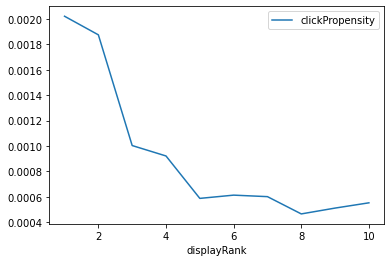

2023-01-05T12:43:20.044+0000: [Full GC (System.gc()) 2023-01-05T12:43:20.044+0000: [Tenured: 47059K->48244K(1398144K), 0.2994344 secs] 268886K->48244K(2027392K), [Metaspace: 130754K->130754K(1173504K)], 0.2995602 secs] [Times: user=0.22 sys=0.08, real=0.30 secs] 


In [32]:
pdf[(pdf["placementId"]==101259)&(pdf["siteId"]==0)].plot.line(x="displayRank", y="clickPropensity")

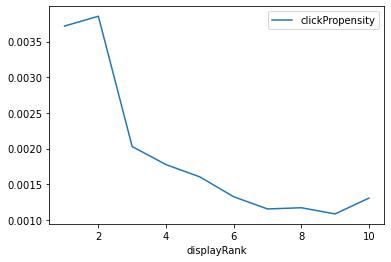

2022-12-12T12:49:17.197+0000: [Full GC (System.gc()) 2022-12-12T12:49:17.197+0000: [Tenured: 54546K->55259K(1398144K), 0.2918338 secs] 273162K->55259K(2027392K), [Metaspace: 129209K->129209K(1171456K)], 0.2919538 secs] [Times: user=0.21 sys=0.08, real=0.29 secs] 


In [18]:
 calc_plot(101251, 0)

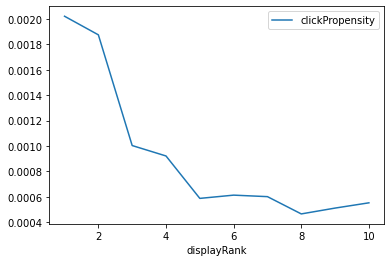

In [43]:
 calc_plot(101259, 0)

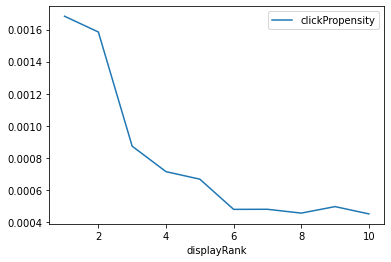

In [16]:
 calc_plot(101260, 0)

In [53]:
sorted(pdf["placementId"].unique())

[101251, 101259, 101260, 101278, 101279, 101280]

In [23]:

sorted(pdf["placementId"].unique())

[101251, 101259, 101260, 101278, 101279, 101280]

In [ ]:
piyi=[101251, 101259, 101260]

In [9]:
clickPropensity=pdf[['siteId','placementId','displayRank','clickPropensity']].drop_duplicates().sort_values(by='siteId')

In [30]:
clickPropensity.shape

(562, 4)

In [60]:
clickPropensity[clickPropensity['siteId']==0].sort_values(by=['placementId', 'displayRank']).head(10)

,siteId,placementId,displayRank,clickPropensity
296,0,101251,1,0.003717
297,0,101251,2,0.003854
298,0,101251,3,0.002029
299,0,101251,4,0.001776
300,0,101251,5,0.001604
301,0,101251,6,0.001326
302,0,101251,7,0.001155
303,0,101251,8,0.001172
304,0,101251,9,0.001085
305,0,101251,10,0.001307


In [19]:
pdf.placementId.isin (piyi)

0      False
1      False
       ...  
560     True
561     True
Name: placementId, Length: 562, dtype: bool

<AxesSubplot:ylabel='Frequency'>

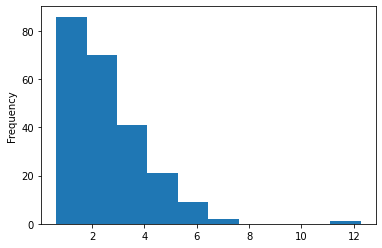

In [20]:
piyi=[101251, 101259, 101260]
pdf.loc[(pdf.propensity_impression_weights>0)& (pdf.placementId.isin (piyi))]["propensity_impression_weights"].plot.hist()

In [22]:
pdf[pdf.placementId.isin (piyi)]['propensity_impression_weights'].max()


12.255851785903735

In [14]:
pd.options.display.max_rows = 4000

In [59]:
pdf[pdf.placementId.isin (piyi)]['propensity_impression_weights'].describe()

count    230.000000
mean       2.495647
std        1.511658
min        0.633840
25%        1.245159
50%        2.202928
75%        3.390089
max       12.255852
Name: propensity_impression_weights, dtype: float64

In [ ]:
clickPropensity['siteId'].nunique()

2022-12-20T10:22:13.224+0000: [Full GC (System.gc()) 2022-12-20T10:22:13.224+0000: [Tenured: 42009K->54472K(1398144K), 0.4326685 secs] 392860K->54472K(2027392K), [Metaspace: 128423K->128423K(1171456K)], 0.4328929 secs] [Times: user=0.27 sys=0.16, real=0.43 secs] 
2022-12-20T10:52:13.224+0000: [Full GC (System.gc()) 2022-12-20T10:52:13.224+0000: [Tenured: 54472K->54759K(1398144K), 0.3415273 secs] 282569K->54759K(2027392K), [Metaspace: 128509K->128509K(1171456K)], 0.3416608 secs] [Times: user=0.24 sys=0.11, real=0.34 secs] 
2022-12-20T11:22:13.224+0000: [Full GC (System.gc()) 2022-12-20T11:22:13.224+0000: [Tenured: 54759K->55602K(1398144K), 0.3588191 secs] 280127K->55602K(2027392K), [Metaspace: 128597K->128597K(1171456K)], 0.3589166 secs] [Times: user=0.23 sys=0.13, real=0.36 secs] 


## Propensity 1/11-27/11

In [42]:
!hdfs dfs -ls -h /apps/b_perso/hp/simplark/pretrainer/PersonalizedTopicsV2WithTopicMLR/2022/11/

Found 7 items
drwxr-xr-x   - b_perso hdmi-mm          0 2022-11-10 02:13 /apps/b_perso/hp/simplark/pretrainer/PersonalizedTopicsV2WithTopicMLR/2022/11/01
drwxr-xr-x   - b_perso hdmi-mm          0 2022-11-11 02:41 /apps/b_perso/hp/simplark/pretrainer/PersonalizedTopicsV2WithTopicMLR/2022/11/02
drwxr-xr-x   - b_perso hdmi-mm          0 2022-11-08 04:31 /apps/b_perso/hp/simplark/pretrainer/PersonalizedTopicsV2WithTopicMLR/2022/11/03
drwxr-xr-x   - b_perso hdmi-mm          0 2022-11-13 04:03 /apps/b_perso/hp/simplark/pretrainer/PersonalizedTopicsV2WithTopicMLR/2022/11/04
drwxr-xr-x   - b_perso hdmi-mm          0 2022-11-14 01:37 /apps/b_perso/hp/simplark/pretrainer/PersonalizedTopicsV2WithTopicMLR/2022/11/05
drwxr-xr-x   - b_perso hdmi-mm          0 2022-11-15 01:33 /apps/b_perso/hp/simplark/pretrainer/PersonalizedTopicsV2WithTopicMLR/2022/11/06
drwxr-xr-x   - b_perso hdmi-mm          0 2022-11-17 01:25 /apps/b_perso/hp/simplark/pretrainer/PersonalizedTopicsV2WithTopicMLR/2022/11/08
2022-1

In [ ]:
file = load_npy_file("part-00049-b694ddb0-e40b-4a1f-9d2d-4f019b7efb74.npy.gz")

In [41]:
!hdfs dfs -ls -h /apps/b_perso/hp/simplark/pretrainer/PersonalizedTopicsV2WithWatchlistFeaturesAndTopicMLR/2022/11/ 

Found 21 items
drwxr-xr-x   - b_perso hdmi-mm          0 2022-11-19 04:43 /apps/b_perso/hp/simplark/pretrainer/PersonalizedTopicsV2WithWatchlistFeaturesAndTopicMLR/2022/11/10
drwxr-xr-x   - b_perso hdmi-mm          0 2022-11-20 02:07 /apps/b_perso/hp/simplark/pretrainer/PersonalizedTopicsV2WithWatchlistFeaturesAndTopicMLR/2022/11/11
drwxr-xr-x   - b_perso hdmi-mm          0 2022-11-21 03:02 /apps/b_perso/hp/simplark/pretrainer/PersonalizedTopicsV2WithWatchlistFeaturesAndTopicMLR/2022/11/12
drwxr-xr-x   - b_perso hdmi-mm          0 2022-11-22 03:05 /apps/b_perso/hp/simplark/pretrainer/PersonalizedTopicsV2WithWatchlistFeaturesAndTopicMLR/2022/11/13
drwxr-xr-x   - b_perso hdmi-mm          0 2022-11-23 03:12 /apps/b_perso/hp/simplark/pretrainer/PersonalizedTopicsV2WithWatchlistFeaturesAndTopicMLR/2022/11/14
drwxr-xr-x   - b_perso hdmi-mm          0 2022-11-24 01:30 /apps/b_perso/hp/simplark/pretrainer/PersonalizedTopicsV2WithWatchlistFeaturesAndTopicMLR/2022/11/15
drwxr-xr-x   - b_perso hd

In [23]:
!hdfs dfs -ls -h /apps/b_perso/hp/simplark/pretrainer/PersonalizedTopicsV2WithWatchlistFeaturesAndTopicMLR/2022/12/ 

Found 15 items
drwxr-xr-x   - b_perso hdmi-mm          0 2022-12-14 09:03 /apps/b_perso/hp/simplark/pretrainer/PersonalizedTopicsV2WithWatchlistFeaturesAndTopicMLR/2022/12/01
drwxr-xr-x   - b_perso hdmi-mm          0 2022-12-14 08:37 /apps/b_perso/hp/simplark/pretrainer/PersonalizedTopicsV2WithWatchlistFeaturesAndTopicMLR/2022/12/02
drwxr-xr-x   - b_perso hdmi-mm          0 2022-12-14 08:49 /apps/b_perso/hp/simplark/pretrainer/PersonalizedTopicsV2WithWatchlistFeaturesAndTopicMLR/2022/12/03
drwxr-xr-x   - b_perso hdmi-mm          0 2022-12-14 07:43 /apps/b_perso/hp/simplark/pretrainer/PersonalizedTopicsV2WithWatchlistFeaturesAndTopicMLR/2022/12/04
drwxr-xr-x   - b_perso hdmi-mm          0 2022-12-14 07:48 /apps/b_perso/hp/simplark/pretrainer/PersonalizedTopicsV2WithWatchlistFeaturesAndTopicMLR/2022/12/05
drwxr-xr-x   - b_perso hdmi-mm          0 2022-12-14 07:32 /apps/b_perso/hp/simplark/pretrainer/PersonalizedTopicsV2WithWatchlistFeaturesAndTopicMLR/2022/12/06
drwxr-xr-x   - b_perso hd

In [ ]:
! hdfs dfs -ls /apps/b_perso/hp/simplark/pretrainer/PersonalizedTopicsV2WithWatchlistFeaturesAndTopicMLR/2022/12/11/data

In [24]:
! hdfs dfs -get /apps/b_perso/hp/simplark/pretrainer/PersonalizedTopicsV2WithWatchlistFeaturesAndTopicMLR/2022/12/11/data/part-00049-b694ddb0-e40b-4a1f-9d2d-4f019b7efb74.npy.gz

In [ ]:
! hdfs dfs -get /apps/b_perso/hp/simplark/pretrainer/PersonalizedTopicsV2WithWatchlistFeaturesAndTopicMLR/2022/12/11/data/part-00049-b694ddb0-e40b-4a1f-9d2d-4f019b7efb74.npy.gz

In [26]:
import os, itertools, gzip
from glob import glob
import numpy as np
def load_npy_file(filepath):
    if filepath.endswith(".gz"):
        with gzip.GzipFile(filepath, 'rb') as f:
            return np.load(f)
    else:
        return np.load(filepath)

In [27]:
file = load_npy_file("part-00049-b694ddb0-e40b-4a1f-9d2d-4f019b7efb74.npy.gz")

In [28]:
file.dtype.names

('meid',
 'algoVariant',
 'siteId',
 'seedId',
 'seedSellerId',
 'l1Cat',
 'l2Cat',
 'l3Cat',
 'category',
 'categoryPath',
 'itemId',
 'sellerId',
 'placementId',
 'seedProduct',
 'PLXModelScore',
 'labels',
 'weight',
 'counterWeight',
 'score',
 'mlrModelScore',
 'boostedFinalScore',
 'rank',
 'postExplorationRank',
 'preMfeRank',
 'impressionClicked',
 'clickPropensity',
 'features',
 'mlrRank',
 'adRate',
 'adRateWeight',
 'price',
 'userId',
 'userAgent',
 'deviceName',
 'eventTimestamp')

In [29]:
file["clickPropensity"].tolist()

[-1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,

2022-12-20T11:52:13.224+0000: [Full GC (System.gc()) 2022-12-20T11:52:13.224+0000: [Tenured: 55602K->42463K(1398144K), 0.3144713 secs] 278693K->42463K(2027392K), [Metaspace: 128667K->128667K(1171456K)], 0.3146640 secs] [Times: user=0.24 sys=0.07, real=0.31 secs] 
2022-12-20T12:22:13.224+0000: [Full GC (System.gc()) 2022-12-20T12:22:13.224+0000: [Tenured: 42463K->43285K(1398144K), 0.3218031 secs] 265977K->43285K(2027392K), [Metaspace: 128781K->128781K(1171456K)], 0.3219020 secs] [Times: user=0.24 sys=0.08, real=0.32 secs] 
2022-12-20T12:52:13.224+0000: [Full GC (System.gc()) 2022-12-20T12:52:13.224+0000: [Tenured: 43285K->43455K(1398144K), 0.2869762 secs] 266222K->43455K(2027392K), [Metaspace: 128803K->128803K(1171456K)], 0.2896558 secs] [Times: user=0.23 sys=0.06, real=0.29 secs] 
2022-12-20T13:22:13.225+0000: [Full GC (System.gc()) 2022-12-20T13:22:13.225+0000: [Tenured: 43455K->44274K(1398144K), 0.3094326 secs] 266446K->44274K(2027392K), [Metaspace: 128856K->128856K(1171456K)], 0.309

In [33]:
f=file['features'].dtype.names

In [34]:
type(f)

tuple

In [ ]:
print([x for x in l1 if 'VB' in x[1]])

In [36]:
print([x for x in f if 'MSKU' in x])

['SpamEditoriallyReviewedMSKUAbuseSeller']


In [37]:
print([x for x in f if 'Msku' in x])

['IsRecoItemMsku', 'TitleMskuVariantHighIdfOrSeedCatPromotedRank', 'IsMskuTraitNameMatch', 'IsMsku']
2022-12-20T14:22:13.224+0000: [Full GC (System.gc()) 2022-12-20T14:22:13.224+0000: [Tenured: 42483K->43320K(1398144K), 0.2993428 secs] 267522K->43320K(2027392K), [Metaspace: 128934K->128934K(1171456K)], 0.2994513 secs] [Times: user=0.24 sys=0.06, real=0.30 secs] 
2022-12-20T14:52:13.224+0000: [Full GC (System.gc()) 2022-12-20T14:52:13.224+0000: [Tenured: 43320K->43487K(1398144K), 0.3614486 secs] 266040K->43487K(2027392K), [Metaspace: 128942K->128942K(1171456K)], 0.3615748 secs] [Times: user=0.27 sys=0.09, real=0.36 secs] 


In [40]:
print([x for x in f if 'SizeMedianDiff' in x])

['SizeMedianDiff', 'SizeMedianDiffMaxMinTh0.5', 'SizeMedianDiffMaxMinTh1', 'SizeMedianDiffMaxMinTh1.5', 'SizeMedianDiffMaxMinThn0.5EvidenceTh1', 'SizeMedianDiffMaxMinThn0.5EvidenceTh4', 'SizeMedianDiffMaxMinThn0.5EvidenceTh8', 'SizeMedianDiffMaxMinTh1EvidenceTh1', 'SizeMedianDiffMaxMinTh1EvidenceTh4', 'SizeMedianDiffMaxMinTh1EvidenceTh8', 'SizeMedianDiffMaxMinTh1.5EvidenceTh1', 'SizeMedianDiffMaxMinTh1.5EvidenceTh4', 'SizeMedianDiffMaxMinTh1.5EvidenceTh8']
